In [1]:
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.max_columns = None

In [2]:
# read in cvs'

orders = pd.read_csv('Orders.csv')
returns = pd.read_csv('Returns.csv')

In [19]:
orders.head()

,Row.ID,Order.ID,Order.Date,Ship.Date,Ship.Mode,Customer.ID,Customer.Name,Segment,Postal.Code,City,State,Country,Region,Market,Product.ID,Category,Sub.Category,Product.Name,Sales,Quantity,Discount,Profit,Shipping.Cost,Order.Priority,year,month
0,40098,CA-2014-AB10015140-41954,2014-11-11,11/13/14,First Class,AB-100151402,Aaron Bergman,Consumer,73120.0,Oklahoma City,Oklahoma,United States,Central US,USCA,TEC-PH-5816,Technology,Phones,Samsung Convoy 3,221.98,2,0.0,62.15,40.77,High,2014,11
1,26341,IN-2014-JR162107-41675,2014-02-05,2/7/14,Second Class,JR-162107,Justin Ritter,Corporate,NaN,Wollongong,New South Wales,Australia,Oceania,Asia Pacific,FUR-CH-5379,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.40,9,0.1,-288.77,923.63,Critical,2014,2
2,25330,IN-2014-CR127307-41929,2014-10-17,10/18/14,First Class,CR-127307,Craig Reiter,Consumer,NaN,Brisbane,Queensland,Australia,Oceania,Asia Pacific,TEC-PH-5356,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.17,9,0.1,919.97,915.49,Medium,2014,10
3,13524,ES-2014-KM1637548-41667,2014-01-28,1/30/14,First Class,KM-1637548,Katherine Murray,Home Office,NaN,Berlin,Berlin,Germany,Western Europe,Europe,TEC-PH-5267,Technology,Phones,"Motorola Smart Phone, Cordless",2892.51,5,0.1,-96.54,910.16,Medium,2014,1
4,47221,SG-2014-RH9495111-41948,2014-11-05,11/6/14,Same Day,RH-9495111,Rick Hansen,Consumer,NaN,Dakar,Dakar,Senegal,Western Africa,Africa,TEC-CO-6011,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.96,8,0.0,311.52,903.04,Critical,2014,11


In [6]:
### Problem 1: Dataset Import & Cleaning
# Check **"Profit"** and **"Sales"** in the dataset, convert these two columns to numeric type. 

In [7]:
orders.Profit.head()

0      $62.15
1    -$288.77
2     $919.97
3     -$96.54
4     $311.52
Name: Profit, dtype: object

In [8]:
# 1. Get rid of $ with .replace and change type to float

orders['Profit'] = orders.Profit.str.replace('[,$]','').astype('float')
orders['Sales'] = orders.Sales.str.replace('[,$]','').astype('float')

In [9]:
# ### Problem 2: Inventory Management
# - Retailers that depend on seasonal shoppers have a particularly challenging job when it comes to inventory management.
# Your manager is making plans for next year's inventory.
# - He wants you to answer the following questions:
#     1. Is there any seasonal trend of inventory in the company?

#     2. Is the seasonal trend the same for different categories?
    
# - ***Hint:*** For each order, it has an attribute called `Quantity` that indicates the number of product in the order.
#     If an order contains more than one product, there will be multiple observations of the same order.

In [10]:
# Create new columns: year and month usuing pd.to_datetime, dt.year and dt.month

orders['Order.Date'] = pd.to_datetime(orders['Order.Date'])
orders['year'], orders['month'] = orders['Order.Date'].dt.year, orders['Order.Date'].dt.month

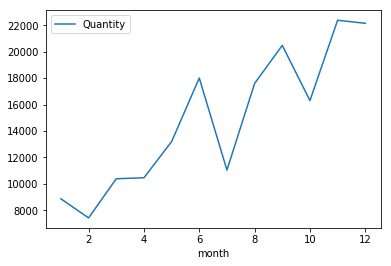

In [11]:
# 2.1
# There are peaks in inventory in June, September, November and December. 
# Inventory decreases dramatically post-Christmas (January, February), July and October.

orders[['month','Quantity']].groupby(['month']).agg(sum).plot()

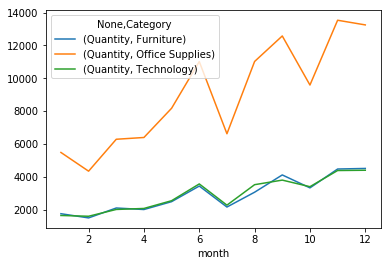

In [12]:
# 2.2    
# Yes but more extreme for office supplies and more gradual for Tech and Furnature

orders[['month','Quantity','Category']].groupby(['month','Category']).agg(sum).unstack().plot()

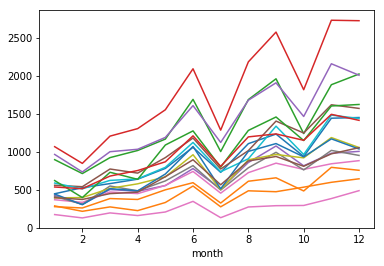

In [13]:
# Plot inventory for sub category as well, for fun. 

orders[['month','Quantity','Sub.Category']].groupby(['month','Sub.Category']).agg(sum).unstack().plot(legend=False)

In [ ]:
# ### Problem 3: Why did customers make returns?
# - Your manager required you to give a brief report (**Plots + Interpretations**) on returned orders.

# 	1. How much profit did we lose due to returns each year?


# 	2. How many customer returned more than once? more than 5 times?


# 	3. Which regions are more likely to return orders?


# 	4. Which categories (sub-categories) of products are more likely to be returned?

# - ***Hint:*** Merge the **Returns** dataframe with the **Orders** dataframe using `Order.ID`.

In [15]:
# Merge data frames

merged = orders.merge(returns, how = 'left', left_on= 'Order.ID', right_on= 'Order ID', left_index= True)
merged.index = merged['Order.Date']

In [16]:
# 3.1

merged.groupby([merged.index.year, 'Returned'])[['Profit']].sum()

,,Profit
Order.Date,Returned,
2012,Yes,17477.26
2013,Yes,9269.89
2014,Yes,17510.63
2015,Yes,17112.97


In [17]:
# 3.2

returners = merged.loc[(merged['Returned'] == 'Yes')].groupby("Customer.ID").size()
print(returners[returners > 1].size)
print(returners[returners > 5].size)

547
46


In [18]:
# 3.3
worst_regions = merged.groupby(['Region_x'])['Returned'].count()
worst_regions

Region_x
Canada                15
Caribbean             69
Central Africa        17
Central America      248
Central Asia           9
Central US            74
Eastern Africa        18
Eastern Asia         131
Eastern Europe        42
Eastern US           134
North Africa          51
Northern Europe       76
Oceania              154
South America        133
Southeastern Asia    140
Southern Africa       25
Southern Asia        111
Southern Europe      112
Southern US           83
Western Africa        60
Western Asia         108
Western Europe       233
Western US           177
Name: Returned, dtype: int64